### Importamos librerias 

In [1]:
import numpy as np
import random


import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

### Feature Selection con GA y DEAP

**Contenido:**

1. Generación del dataset y creación de la función de evaluación.
2. Instanciación del toolbox de DEAP y configuración del problema y los operadores.
3. Generación de un Algoritmo Genético Simple codeado por nosotros.

![](../images/deap_logo.png)

###  1. Generación del dataset y creación de la función de evaluación.

#### Generamos el dateset y definimos el modelo a utilizar 

In [2]:
# Definimos la cantidad de features a utilizar
n_features = 15

# Seteamos verbose en false
verbose = 0

In [3]:
# Inicialmente lo que haremos es generar el dataset
X, y = make_classification(n_samples=1000, n_features=n_features, n_classes=2, n_informative=4, 
                           n_redundant=1, n_repeated=2, random_state=1)

In [4]:
# Luego defineremos el modelo a utilizar
model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')

#### Creamos las funciones auxiliares para realizar la evaluacion 

In [5]:
# Por ultimo generaremos las funciones de evaluacion
def calculate_fitness(model, x, y):
    cv_set = np.repeat(-1.0, x.shape[0])
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if x_train.shape[0] != y_train.shape[0]:
            raise Exception()
        model.fit(x_train, y_train)
        predicted_y = model.predict(x_test)
        cv_set[test_index] = predicted_y
    return f1_score(y,cv_set)

In [6]:
def evaluate(individual):
    np_ind = np.asarray(individual)
    if np.sum(np_ind) == 0:
        fitness = 0.0
    else:
        feature_idx = np.where(np_ind == 1)[0]
        fitness = calculate_fitness(
            model, X[:, feature_idx], y
        )
        if verbose:
            print("Individuo: {}  Fitness Score: {} ".format(individual, fitness))

    return (fitness,)

### 2.  Instanciación del toolbox de DEAP y configuración del problema y los operadores.

#### Definimos el tipo de problema e instanciamos el Toolbox 

In [7]:
# En primer lugar definimos si es un problema de maximización o minimización
# Esto sea seteando los pesos en "1.0"
creator.create("FeatureSelect", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FeatureSelect)

toolbox = base.Toolbox()

#### Configuramos a nuestro individuo y a nuestra poblacion 

In [8]:
# Definimos como estara conformado nuestro inviduo
# En nuestro caso sera un vector de 0 y 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Luego definimos que nuestro inviduo ademas tendra la longitud = n_features
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)

# Configuramos a nuestra poblacion, indicando como son los individuos que la conformaran
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

**Recursos:**  
Para más información revisar la documentación de **[DEAP](https://deap.readthedocs.io/en/master/)**.

#### Definimos los operadores 

![](../images/ga_operators.png)

In [9]:
toolbox.register("mate", tools.cxTwoPoint) # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1) # Mutacion
toolbox.register("select", tools.selTournament, tournsize=3) # Selecion
toolbox.register("evaluate", evaluate) # Evaluacion

**Recursos:**  
Por cada operador existen diferentes variantes. Para ver cuáles están disponibles revisar la documentación de **[DEAP](https://deap.readthedocs.io/en/master/api/tools.html#operators)**.

### 3. Generación de un Algoritmo Genético Simple codeado por nosotros. 

#### Definimos algunas constantes

In [10]:
N_POP = 100 # Tamaño de la población
CXPB = 0.5 # Probabilidad de crossover
MUTPB = 0.2 # Probabilidad de mutación
NGEN = 10 # Cantidad de generaciones

In [11]:
print(
    "Tamaño población: {}\nProbabilidad de crossover: {}\nProbabilida de mutación: {}\nGeneraciones totales: {}".format(
        N_POP, CXPB, MUTPB, NGEN
    )
)

Tamaño población: 100
Probabilidad de crossover: 0.5
Probabilida de mutación: 0.2
Generaciones totales: 10


#### Algoritmo Genetico

In [12]:
# Inicializamos a la poblacion
pop = toolbox.population(N_POP)

In [13]:
hof   = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Estadisticas
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)


# Algoritmo
pop, logbook = algorithms.eaMuPlusLambda(pop, 
                                         toolbox, 
                                         mu=N_POP, 
                                         lambda_=N_POP,
                                         cxpb=CXPB,   
                                         mutpb=MUTPB, 
                                         ngen=NGEN, 
                                         stats=stats, 
                                         halloffame=hof)

gen	nevals	avg         	std         	min    	max         
0  	100   	[0.74508698]	[0.07034585]	[0.482]	[0.80855199]
1  	60    	[0.7918907] 	[0.00922879]	[0.76305221]	[0.81170732]
2  	70    	[0.79876102]	[0.00642624]	[0.78957916]	[0.81170732]
3  	69    	[0.8041808] 	[0.00663028]	[0.792]     	[0.8125]    
4  	75    	[0.80857382]	[0.00376712]	[0.79561316]	[0.8128655] 
5  	78    	[0.81113711]	[0.00171753]	[0.8054741] 	[0.8128655] 
6  	69    	[0.81207102]	[0.00064923]	[0.80901077]	[0.8128655] 
7  	74    	[0.81259919]	[0.00041336]	[0.81170732]	[0.8128655] 
8  	69    	[0.81285088]	[7.16225071e-05]	[0.8125]    	[0.8128655] 
9  	65    	[0.8128655] 	[2.22044605e-16]	[0.8128655] 	[0.8128655] 
10 	73    	[0.8128655] 	[2.22044605e-16]	[0.8128655] 	[0.8128655] 


**NOTA:**  
Exista una amplia variedad de algoritmos que nos provee DEAP. Para ver cuáles están disponibles ingresar a la documentación de **[DEAP](https://deap.readthedocs.io/en/master/api/algo.html)**.

#### Seleccion del mejor individuo 

In [14]:
# Seleccionamos a la mejor solucion
best_solution = tools.selBest(pop, 1)[0]
print(
    "El mejor individuo es: \n{}, con un F1 Score de {}".format(best_solution, best_solution.fitness.values)
)

El mejor individuo es: 
[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], con un F1 Score de (0.8128654970760234,)


#### Graficamos el score promedio de cada generacion 

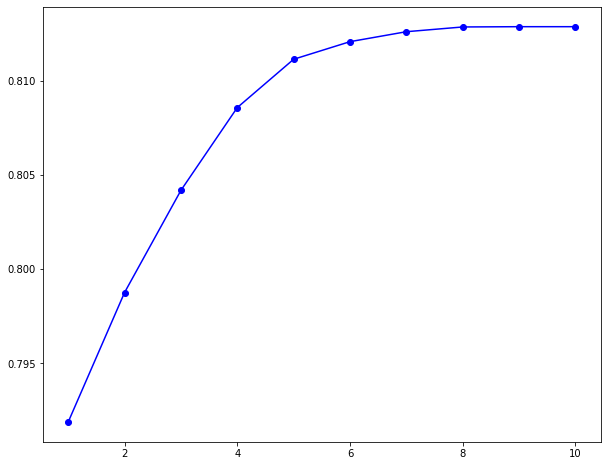

In [15]:
# Ploteamos el AVG por generacion
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:], front[:,1][1:], "-bo", c="b")
plt.axis("tight")
plt.show()